In [11]:
# imports
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel,SharedOperatorPDEModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM
from Optimizers.solvers_base import *
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})


In [12]:
m = 16
obs_pts = 2
run = 0

In [13]:
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = run
                                    )
                                    )
# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(run)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init)

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)


In [17]:
def plot_function(
    obs_points,
    all_points,
    func,
    fine_grid,
    xlabel = r'$t$',
    ylabel = r'$x$',
    level_sets = 70,
    include_collocation = True,
    include_observations = True
):

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(*fine_grid.T,func(fine_grid),level_sets)
    cb = plt.colorbar()
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=4)
    plt.tight_layout()
    if include_collocation is True:
        plt.scatter(*all_points.T,c='gray',s = 5,label = "Collocation Point")
    if include_observations is True:
        plt.scatter(*obs_points.T,c='red', s = 50, alpha = 0.5,label = "Function Value Observed")


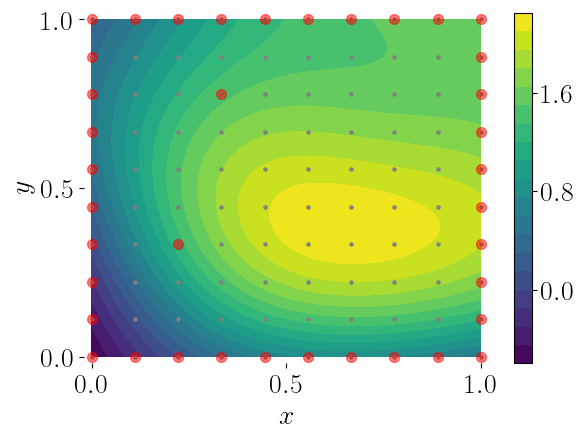

In [18]:
# Define fine grid to plot
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

plot_function(
    xy_obs[0],
    xy_all[0],
    vmapped_u_true_functions[0],
    xy_fine,
    xlabel = r'$x$',
    ylabel = r'$y$',
    level_sets=20,
    include_collocation = True
)

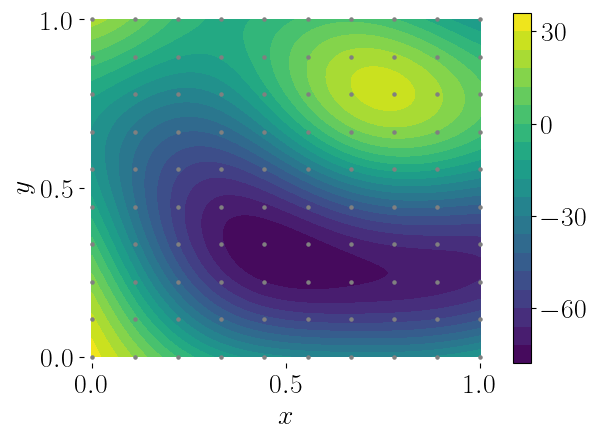

In [19]:
plot_function(
    xy_obs[0],
    xy_all[0],
    rhs_functions[0],
    xy_fine,
    xlabel = r'$x$',
    ylabel = r'$y$',
    level_sets=20,
    include_collocation = True,
    include_observations= False
)

In [20]:
u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )


  0%|          | 0/501 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [11]:
all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])


In [12]:
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
table_u_errors(xy_fine,(u_model,)*m,u_sol,list(map(jax.vmap,u_true_functions)),all_u_params_init)

,Percent error 1 step,Percent error 2 step (at init)
0,0.119572,0.341600
1,0.166481,0.413986
2,0.083387,0.419387
3,0.096609,0.244763
4,0.086089,0.387169
5,0.176502,0.431386
6,0.105073,0.329043
7,0.146167,0.610359
8,0.184844,0.700610
9,0.112746,0.302225


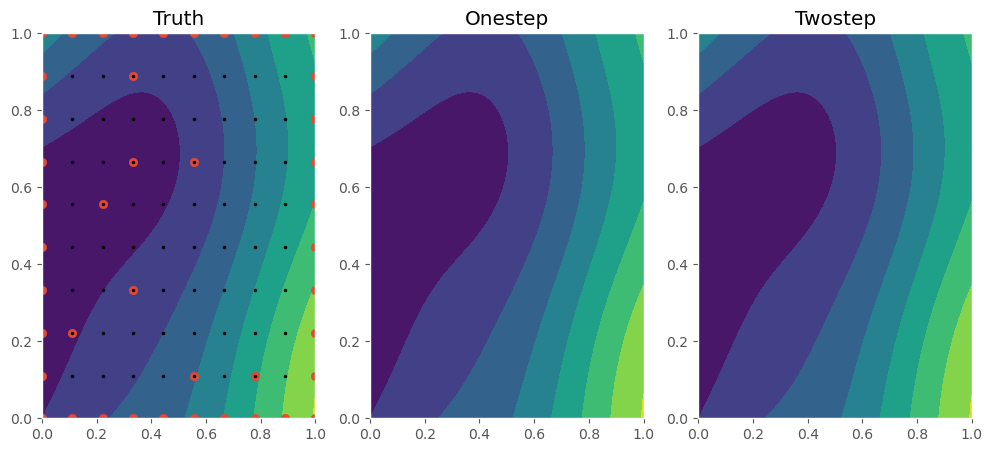

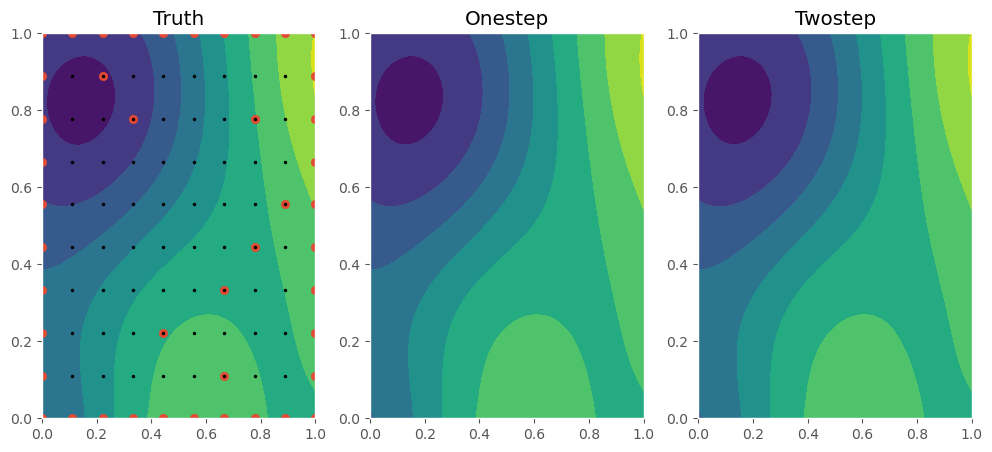

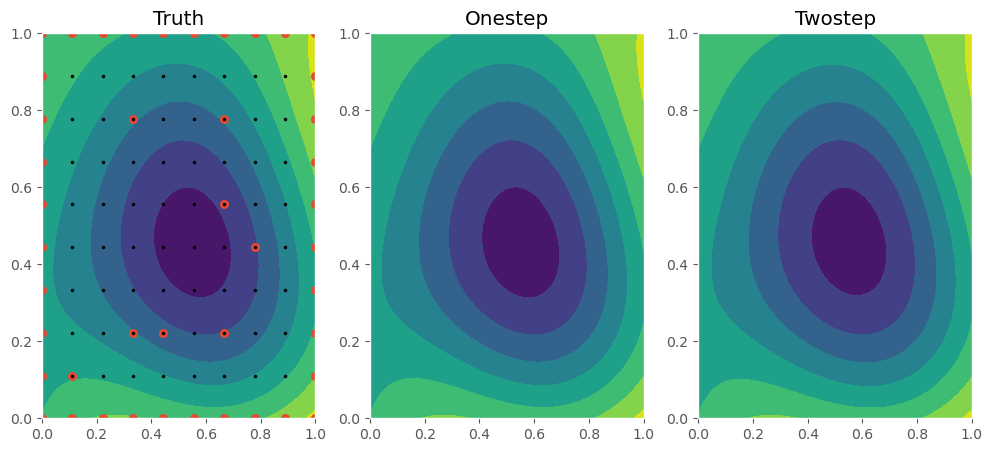

In [13]:
for i in range(m):
    xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
    solution_index = i
    true_func_vals = jax.vmap(u_true_functions[solution_index])(xy_fine)
    onestep_vals = u_model.point_evaluate(xy_fine,u_sol[solution_index])
    interpolant_vals = u_model.point_evaluate(xy_fine,u_init[solution_index])
    # print("1step NRMSE: ",get_nrmse(true_func_vals,onestep_vals),"interpolant NRMSE: ",get_nrmse(true_func_vals,interpolant_vals))
    if i<3:
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        
        plt.tricontourf(*xy_fine.T,true_func_vals)
        plt.scatter(*xy_obs[i].T)
        plt.scatter(*collocation_points[0].T,c='black',s = 4)
        plt.title("Truth")
        plt.subplot(1,3,2)
        plt.tricontourf(*xy_fine.T,onestep_vals)
        plt.title("Onestep")
        plt.subplot(1,3,3)
        plt.tricontourf(*xy_fine.T,interpolant_vals)
        plt.title("Twostep")
        plt.show()


In [14]:
# Backward operator error

# Testing grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Simulate u
M = 1

kernel_GP = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_news_ = GP_sampler(num_samples = M,
                X = xy_pairs, 
                kernel = kernel_GP,
                reg = 1e-12,
                seed = run
                )
u_news = tuple([jax.vmap(u_new_) for u_new_ in u_news_]) # vmap'ed
f_news = tuple([jax.vmap(get_rhs_darcy(u_new_)) for u_new_ in u_news_]) #vmap'ed

# 1_5 step

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new,method):
    
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)
                
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = jnp.where(method == 1, get_pred_hatP(P_features), get_pred_hatP2step(P_features))
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )

    # u_params_pde,_ = CholeskyLM(
    #     new_u_init.copy(),
    #     PdeModel,
    #     beta = 0.,
    #     max_iter = 101,
    #     init_alpha=0.05,
    #     line_search_increase_ratio=1.4,
    #     print_every = 10
    # )

    # u_pde_adj,_ = SVD_LM(u_params_pde,PdeModel,1e-1,150)

#     u_pde_adj,_ = SVD_LM(
#     u_params_pde,
#     EqnModel,
#     beta = 1e-13,
#     optParams = optparams
# )

    return u_params_pde



# # Define fine grid to test
# num_fine_grid = 50
# x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
# xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

true = [u_new(xy_fine) for u_new in u_news]

pred1_5 = [
    u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=1))
    for u_new,f_new in zip(u_news,f_news)
]    

pred2 = [
    u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=2))
    for u_new,f_new in zip(u_news,f_news)
]

i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

  0%|          | 1/301 [00:30<2:32:22, 30.47s/it]

Iteration 0, loss = 0.0003474, gradnorm = 1.364e+03, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:31<1:04:14, 12.89s/it]

Iteration 1, loss = 0.0002005, gradnorm = 0.0003313, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:31<36:06,  7.27s/it]  

Iteration 2, loss = 0.0001468, gradnorm = 0.0001065, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:32<22:54,  4.63s/it]

Iteration 3, loss = 0.0001185, gradnorm = 7.058e-05, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:32<15:38,  3.17s/it]

Iteration 4, loss = 0.0001028, gradnorm = 4.839e-05, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:33<11:15,  2.29s/it]

Iteration 5, loss = 9.303e-05, gradnorm = 3.441e-05, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [01:28<01:56,  1.72it/s]

Iteration 100, loss = 1.6e-06, gradnorm = 1.38e-07, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [02:26<00:58,  1.72it/s]

Iteration 200, loss = 9.211e-07, gradnorm = 5.232e-07, alpha = 8.333e-09, improvement_ratio = 0.9983


100%|██████████| 301/301 [03:24<00:00,  1.47it/s]

Iteration 300, loss = 8.892e-07, gradnorm = 2.621e-06, alpha = 8.333e-09, improvement_ratio = 1.009



  0%|          | 1/301 [00:32<2:41:34, 32.32s/it]

Iteration 0, loss = 0.009521, gradnorm = 1.36e+03, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:33<1:09:39, 13.98s/it]

Iteration 1, loss = 0.006909, gradnorm = 0.0009825, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:34<40:18,  8.12s/it]  

Iteration 2, loss = 0.005547, gradnorm = 0.0005425, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:35<26:32,  5.36s/it]

Iteration 3, loss = 0.00474, gradnorm = 0.000388, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:36<18:56,  3.84s/it]

Iteration 4, loss = 0.004247, gradnorm = 0.0002869, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:38<14:21,  2.92s/it]

Iteration 5, loss = 0.003936, gradnorm = 0.0002189, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [02:26<03:47,  1.14s/it]

Iteration 100, loss = 6.471e-05, gradnorm = 1.163e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [04:20<01:53,  1.14s/it]

Iteration 200, loss = 2.858e-05, gradnorm = 8.695e-06, alpha = 8.333e-09, improvement_ratio = 1.001


100%|██████████| 301/301 [06:14<00:00,  1.24s/it]

Iteration 300, loss = 2.43e-05, gradnorm = 1.36e-05, alpha = 8.333e-09, improvement_ratio = 0.9999


In [15]:
i_opt_1_5

Array(0.00119738, dtype=float64)

In [16]:
i_opt_2

Array(0.00649349, dtype=float64)

: 

In [ ]:
# Operator learning error 
def run_exp_opt_err(m,obs_pts,run):
    '''
    Computes operator learning error for 1 step and 2 step methods.

    Args:
        m (int): Number of functions.
        obs_pts (int): Number of observed points.
        run (int): seed.
    
    Returns:
        i_opt_1_5 (float): Error for Phat (1 step) for in-sample functions.
        i_opt_2 (float): Error for Phat (2 step) for in-sample functions.

    '''
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


    # Sample collocation points for f using same uniform grid for every function
    xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
    xy_ints = (xy_int_single,)*m
    xy_bdys = (xy_bdy_single,)*m


    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(run)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)

    # u_models = tuple([CholInducedRKHS(
    #     xy_all[i],
    #     u_operators,
    #     k_u
    #     ) for i in range(m)])

    u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints


    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
        for obs_loc,obs_val in zip(observation_points,observation_values)])

    grid_features_u_init = jnp.vstack([(
        u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

    grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
    k_P_x_part = get_gaussianRBF(0.4)

    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
        

    # P object        
    P_model = InducedOperatorModel(grid_features_u_init,k_P)
    num_P_params = len(grid_features_u_init) 

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = SharedOperatorPDEModel(
        P_model,
        u_model,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
        num_P_operator_params = 200
    )

    # OPTIMIZE

    u_init = jnp.stack(all_u_params_init)
    P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

    beta_reg = 1e-8

    from Optimizers import BlockArrowLM,LMParams
    lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
    u_sol,P_sol,arrow_conv = BlockArrowLM(
        u_init,P_init,EqnModel,beta_reg,beta_reg,
        optParams=lm_params
        )
    
    # Backward operator error

    # Testing grid
    xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

    # Simulate u
    M = 5

    kernel_GP = get_gaussianRBF(0.5) # Same regularity as training u's
    # Sample M training functions from GP(0,K)
    u_news_ = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    u_news = tuple([jax.vmap(u_new_) for u_new_ in u_news_]) # vmap'ed
    f_news = tuple([jax.vmap(get_rhs_darcy(u_new_)) for u_new_ in u_news_]) #vmap'ed

    # 1_5 step

    # Collocation points where to solve for \hat P (u) = f_new
    num_interior_points = 256
    num_grid_points = 20
    # Sample collocation points for learning u
    xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
            num_functions = 1,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(0)
        )
    # Boundary pairs
    xy_bdy = xy_boundarys[0]
    # Interior pairs (where PDE is satisfied)
    xy_int = xy_interiors[0]
    # Union of xy_bdy
    xy_all = jnp.vstack([xy_int,xy_bdy])

    # u_new object
    u_model = CholInducedRKHS(
        xy_all,
        feature_operators,
        k_u
        )

    def get_u_pde_adj(u_new,f_new,method):
        
        @jit
        def get_pred_hatP(input_features):
            return P_model.predict(input_features,P_sol)
                    
        @jit
        def get_pred_hatP2step(input_features):
            init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                    for u_params,eval_points in zip(
                                                    all_u_params_init,
                                                    EqnModel.collocation_points)])
            rhs_stacked = EqnModel.stacked_collocation_rhs
            P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
            return P_model.predict(input_features,P_params_naive)

        

        new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


        class PdeModel():

            datafit_weight = 50.

            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
                grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
                return jnp.hstack([xy_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return f_new(xy_int)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(xy_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = jnp.where(method == 1, get_pred_hatP(P_features), get_pred_hatP2step(P_features))
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        
        # Optimize
        new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

        # Optimizer hyperparameters
        optparams = LMParams(max_iter = 301,
                            line_search_increase_ratio = 1.4,
                            print_every = 100,
                            tol = 1e-10)
        
        u_params_pde, _ = CholeskyLM(
            new_u_init.copy(),
            PdeModel,
            beta = 0,
            optParams = optparams
        )


        return u_params_pde

    true = [u_new(xy_fine) for u_new in u_news]

    pred1_5 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=1))
        for u_new,f_new in zip(u_news,f_news)
    ]    

    pred2 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=2))
        for u_new,f_new in zip(u_news,f_news)
    ]

    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))
    



    return i_opt_1_5, i_opt_2